# Machine Learning-based Stock Trader

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

from indicators import *
from market_simulator import *
from MLTrader import MLTrader

## Testing Ridge Regressor

### Training Model

In [2]:
#storing the symbol to trade, starting and ending dates for trading
symbol = 'AAPL'
sd = '2012-01-01'
ed = '2013-12-31'

#reading in adjusted closing prices
prices = pull_prices(symbol, sd, ed)

#normalizing the prices
ss = StandardScaler()
prices_norm = pd.DataFrame(ss.fit_transform(prices),index=prices.index, columns=[symbol])

#generating the indicators from the price data
n = 10
trader = MLTrader(Ridge, n = n)
indicators = trader.generate_indicators(prices_norm)

#removing the first n rows of the indicators df to remove nulls 
indicators = indicators.iloc[n:,:]

#removing the first n rows of the prices df to match the indicators df
prices_norm = prices_norm.iloc[n:,:]

#using ridge regression to predict the stock prices
model = Ridge(alpha=0.001, random_state=0)
model.fit(indicators, prices_norm)
prices_pred = model.predict(indicators)

#scoring model
print("R-Squared of Model: %0.5f"%model.score(indicators, prices_norm))

[*********************100%***********************]  1 of 1 completed
R-Squared of Model: 0.98849


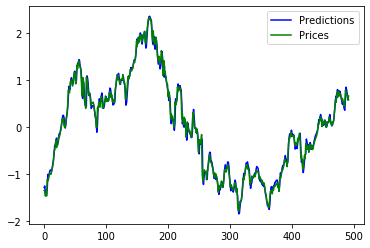

In [3]:
plt.plot(prices_pred, color='b', label='Predictions')
plt.plot(prices_norm.values, color='g', label='Prices')
plt.legend()
plt.show()

### Testing Model

In [4]:
#storing the symbol to trade, starting and ending dates for trading
symbol = 'AAPL'
sd = '2017-01-01'
ed = '2018-12-31'

#reading in adjusted closing prices
prices = pull_prices(symbol, sd, ed)

#normalizing the prices
prices_norm = pd.DataFrame(ss.transform(prices),index=prices.index, columns=[symbol])

#generating the indicators from the price data
indicators = trader.generate_indicators(prices_norm)

#removing the first n rows of the indicators df to remove nulls 
indicators = indicators.iloc[n:,:]

#removing the first n rows of the prices df to match the indicators df
prices_norm = prices_norm.iloc[n:,:]

#predicting the stock price
prices_norm["Predicted Price"] = model.predict(indicators)
prices_norm.head()

[*********************100%***********************]  1 of 1 completed


,AAPL,Predicted Price
Date,,
2017-01-18,5.219129,5.187884
2017-01-19,5.197639,5.170670
2017-01-20,5.220154,5.163929
2017-01-23,5.228339,5.193734
2017-01-24,5.217082,5.176215



R-Squared of Model: 0.98870


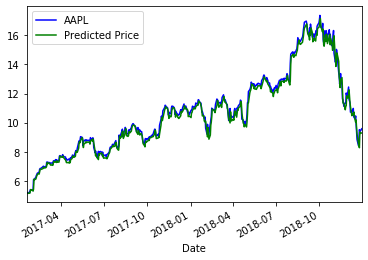

In [5]:
#scoring model
print()
print("R-Squared of Model: %0.5f"%model.score(indicators, prices_norm.iloc[:,0]))

prices_norm.plot(color=['b','g'])
plt.legend()
plt.show()

## Using MLTrader Class to Make Stock Trading Decisions

In [6]:
import datetime
from dateutil.relativedelta import relativedelta
t = datetime.datetime.today()
print(t - relativedelta(months=1))

2019-12-29 16:23:01.662884


In [7]:
def test_code(learner, orders_df, sd, ed, symbol, sv, plot_title):
    #reading in stock prices over the given date range
    prices = pull_prices(symbol, sd, ed).iloc[10:,:]
    
    #test trades using market simulator
    portvals = simulator(orders_df, start_val = sv, commission=9.95, impact=0.005)

    prices['MLTrader'] = portvals
    prices['Predicted Price'] = learner.prices_pred
    plot_winnings(prices, plot_title, ["MLLearner",
                  "Prices"], [], [])
    adr,sddr,cr = port_stats(portvals)

    # Print statistics
    print(f"Start Date: {sd}")
    print(f"End Date: {ed}")
    print(f"Symbol: {symbol}")
    
    print(f"Std Dev of Daily Returns: %.5f"%sddr)
    print(f"Average Daily Return: %.5f"%adr)
    print(f"Cumulative Return: %.5f"%cr)


######################   In-Sample   #######################

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


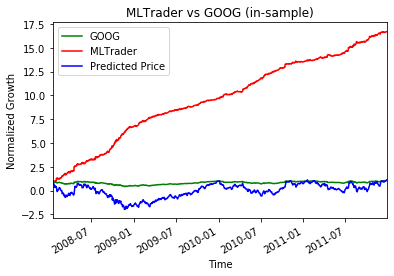

Start Date: 2008-01-01
End Date: 2011-12-31
Symbol: GOOG
Std Dev of Daily Returns: 0.01544
Average Daily Return: 0.00294
Cumulative Return: 15.73638

######################  Out-of-Sample  ######################

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


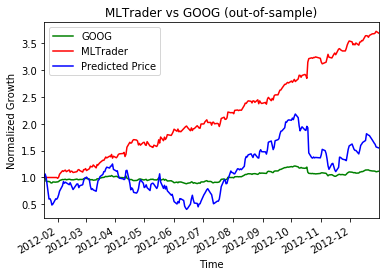

Start Date: 2012-01-01
End Date: 2012-12-31
Symbol: GOOG
Std Dev of Daily Returns: 0.02223
Average Daily Return: 0.00572
Cumulative Return: 2.68775


In [8]:
#initializing object
trader = MLTrader(n=10, learner=Ridge, kwargs={'alpha':0.001, 'random_state':0}, impact = 0.005)

#in-sample parameters
symbol = "GOOG"
sd = "2008-01-01"
ed = "2011-12-31"

sv = 100000

print()
print("######################   In-Sample   #######################")
print()

#training regressor
trader.fit(symbol, sd, ed, sv)

#creating orders dataframe
trades_df = trader.testLearner(symbol, sd, ed, sv)
orders_df = trader.generate_orders_df(trades_df, symbol)

#testing regressor
test_code(trader, orders_df, sd, ed, symbol, sv,
          "MLTrader vs %s (in-sample)"%symbol)


print()
print("######################  Out-of-Sample  ######################")
print()

#out-of-sample dates
sd = "2012-01-01"
ed = "2012-12-31"

#creating orders dataframe
trades_df = trader.testLearner(symbol, sd, ed, sv)
orders_df = trader.generate_orders_df(trades_df, symbol)

test_code(trader, orders_df, sd, ed, symbol, sv,
          "MLTrader vs %s (out-of-sample)"%symbol)

In [9]:
print("Number of Predictions: %0.0f"%trader.trades)
print("Number of Mismatches: %0.0f"%trader.bad_trades)
print("Percent of Bad Trades: %0.2f %%"%(100*np.divide(trader.bad_trades,trader.trades)))

Number of Predictions: 213
Number of Mismatches: 61
Percent of Bad Trades: 28.64 %


## Saving MLTrader's ML Model

In [10]:
trader.save_learner(symbol)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


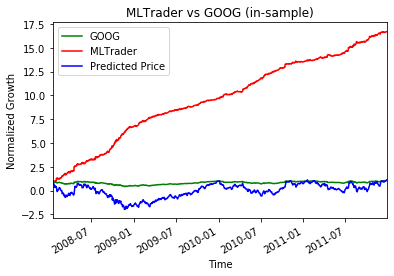

Start Date: 2008-01-01
End Date: 2011-12-31
Symbol: GOOG
Std Dev of Daily Returns: 0.01544
Average Daily Return: 0.00294
Cumulative Return: 15.73638

######################  Out-of-Sample  ######################

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


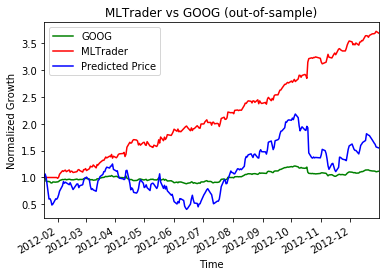

Start Date: 2012-01-01
End Date: 2012-12-31
Symbol: GOOG
Std Dev of Daily Returns: 0.02223
Average Daily Return: 0.00572
Cumulative Return: 2.68775


In [11]:
#stock price parameters
symbol = "GOOG"
sd = "2008-01-01"
ed = "2011-12-31"
sv = 100000

#initializing object and loading the ML learner
trader = MLTrader(n=10, learner=Ridge, impact = 0.005,
                  kwargs={'alpha':0.001, 'random_state':0})
trader.load_learner(symbol)

#creating orders dataframe
trades_df = trader.testLearner(symbol, sd, ed, sv)
orders_df = trader.generate_orders_df(trades_df, symbol)

#testing regressor
test_code(trader, orders_df, sd, ed, symbol, sv,
          "MLTrader vs %s (in-sample)"%symbol)


print()
print("######################  Out-of-Sample  ######################")
print()

#out-of-sample dates
sd = "2012-01-01"
ed = "2012-12-31"

#creating orders dataframe
trades_df = trader.testLearner(symbol, sd, ed, sv)
orders_df = trader.generate_orders_df(trades_df, symbol)

test_code(trader, orders_df, sd, ed, symbol, sv,
          "MLTrader vs %s (out-of-sample)"%symbol)